### Requisitos del proyecto
Debe contener lo siguiente:

1. Explicación del problema a resolver (cuáles son los inputs y porqué, cual es la salida y porqué, cómo se obtuvieron y de dónde)
2. Análisis de los datos (histogramas, visualización de una muestra tanto la entrada como la salida, normalización encaso de ser necesaria)
3. Separación de los datos (seleccionar un porcentaje para cada conjunto)
4. Definición, Entrenamiento y Evaluación de la red neuronal
5. Inferencia (usando los datos de prueba)
6. Comentario: explicar porqué se obtuvieron esos resultados

# LaTeX Parser

### I. Explicación del problema
_____
_____

El problema a resolver es la traducción de imágenes con ecuaciones matemáticas a una secuencia de símbolos que $\LaTeX$ utiliza para generar ecuaciones matemáticas:

![traduccion](images/diag2.png)

Para ello se empleará el modelo *Sequence-to-Sequence* (S2S), este modelo es un caso especial de una familia general de modelos llamados: *encoder-decoder models*, que son una composición de dos modelos: *encoder* y *decoder*, que suelen ser entrenados en conjunto.

![encoder-decoder](images/encoder-decoder.png)

El modelo encoder es usualmente una red neuronal convolucional (CNN) que transforma imágenes en un grupo de mapas de características, o una representación $(\Phi)$, que es generalmente un vector. El decoder por otro lado, es usualmente una red enuronal recurrente (RNN) que tiene como meta tomar la representación ($\Phi$) de la entrada y producir la salida deseada. A partir de lo anterior, se puede definir a los modelos S2S como modelos encoder-decoder, en los que el encoder y el decoder son modelos de secuencia y las entradas y salidas son secuencias, posiblemente de diferentes longitudes.

#### I.I Entrada y salida (Contexto a la solución del problema)   
___



Si se define a una imagen de una ecuación matemática generada con LaTeX como: $(x,y)$, en donde $x \in \mathbb{R}^{H \times W}$ es una imagen en escala de grises de altura $H$ y ancho $W$, $y = [y_1,...y_T]$ es una secuancia de $T$ símbolos que definen la fórmula matemática de la imagen. La meta es obtener la salida $y$ a partir de la entrada $x$, es decir, encontrar una función $f: f(x) \longrightarrow y$.  

Dado un conjunto de imágenes $(x_i,y_i)\,i \in \{1,...,N\}$, se puede usar entrenamiento supervisado para construir una función de predicción de secuencia $f'$ que aproxime a $f$, $f': f'(x) \longrightarrow y'$, para predecir una secuencia de $LaTeX$ $y'$ que reconstruya la imagen $x$. La evaluación se puede realizar mediante la comparación de $y'$ y $y$, y entre la imagen $x'$ creada a partir de $y'$, con la original $x$.

#### I.II Obtención de los datos
___

Los datos se obtuvieron de la página [LSTMVis](http://lstm.seas.harvard.edu/), una herramienta de análisis visual para redes neuronales.

Para descargar el conjunto de datos:  
- Estar en la carpeta de images: `cd src/data/sets/raw/images`
- Descargar el dataset: `sudo tar -zxvf formula_images_processed.tar.gz`
- Comando sugerido para copiar los datos .png una vez descomprimidos a la carpeta de images:  
`find /src/data/sets/raw/images/formula_images_processed/ -name "*.png" -exec cp -uf "{}" /src/data/sets/raw/images/ \;`


**Referencias:**  
[1] Delip Rao & Brian McMahan, *Natural Language Processing with PyTorch*, (2019) Chapter 8.  
[2] [Translating Math Formula Images to LaTeX Sequences Using Deep Neural Networks with Sequence-level Training](https://arxiv.org/pdf/1908.11415.pdf)  
[3] [Image-to-Markup Generation with Coarse-to-Fine Attention](http://lstm.seas.harvard.edu/latex/)

### II. & III. Análisis de los datos y Separación de datos
___
___

Importación de librerías

In [1]:
# Dependencies 
import random
import statistics
from functools import partial
import time
import tqdm

In [2]:
# TORCH
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# PROJECT
from architecture import *

from data import DataBuilder

from utilities.dataloaders import *
from utilities.training import *
from utilities.latex_gen import *

from utilities.tensor import *
from utilities.persistance import *
from utilities.logger import *

In [4]:
# Hardware
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_workers = 4 #2

División de los datos en conjuntos train, validation y test / hiperparámetros de entrenamiento:

In [5]:
# ********************************************************************
# **********************  Hyper parameters  **************************
# ********************************************************************
    
# data
num_data_train = 100000  # max
num_data_val = 20000  # max
num_data_test = 2000  # max
batch_size = 20 #50
    
# training
epochs = 10  # default 10
learning_rate = 3e-4 #default 3e-4
drop_out = 0.2 # default 0.2
clip = 2 #default 2

Obtención de los datos:  
(Para ver los códigos de la obtención de datos: `/src/data/`)

In [6]:
# ********************************************************************
# **********************  Get data  **********************************
# ********************************************************************
data_builder = DataBuilder()

vocabulary = data_builder.get_vocabulary()

force = True
train_dataset = data_builder.get_dataset_for('train', max_count=num_data_train, force=force)
valid_dataset = data_builder.get_dataset_for('validate', max_count=num_data_val, force=force)
test_dataset = data_builder.get_dataset_for('test', max_count=num_data_test, force=force)

num_data_train = len(train_dataset)
num_data_val = len(valid_dataset)
num_data_test = len(test_dataset)

print("+"*8+" Información sobre el número de datos: "+"+"*8)
print("Número de datos train:", num_data_train)
print("Número de datos validation:", num_data_val)
print("Número de datos test:", num_data_test)


++++++++ Información sobre el número de datos: ++++++++
Número de datos train: 75275
Número de datos validation: 8370
Número de datos test: 2000


Visualización de dos datos de entrada y salida:

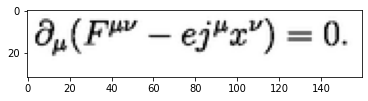

\partial _ { \mu } ( F ^ { \mu \nu } - e j ^ { \mu } x ^ { \nu } ) = 0 .


In [12]:
# Imagen como entrada
show_tensor_as_image(train_dataset[6][0])

# Latex como salida
print(train_dataset[6][1])

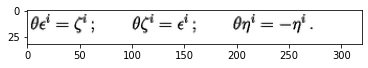

\theta \epsilon ^ { i } = \zeta ^ { i } \, ; \qquad \theta \zeta ^ { i } = \epsilon ^ { i } \, ; \qquad \theta \eta ^ { i } = - \eta ^ { i } \, .


In [13]:
# Image como entrada
show_tensor_as_image(train_dataset[50][0])
# Latex como salida
print(train_dataset[50][1])

### IV. Definición, Entrenamiento y Evaluación  
___
___

#### IV.I Arquitectura de la red

In [14]:
# ********************************************************************
# **********************  Architecture  ******************************
# ********************************************************************

model = Model(
out_size=len(vocabulary),
enc_out_dim=512,
emb_size=80,
dec_rnn_h=512,
dropout=drop_out
)

Para ver el código del modelo completo: `/src/architecture/model.py` 

#### IV.II Entrenamiento

In [15]:
# ********************************************************************
# **********************  Training  **********************************
# ********************************************************************

# Hyper parameters for training 
init_epoch = 1

# For epsilon calculation
decay_k = 1 #default
sample_method = "inv_sigmoid" #default ["exp", "inv_sigmoid", "teacher_forcing")

# Dataloaders
train_loader = DataLoader (
    train_dataset,
    batch_size=batch_size,
    #TODO how collate works?
    # https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278
    collate_fn=partial(collate_fn, vocabulary.token_id_dic),
    pin_memory=False, # It must be False (no GPU): https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723
    #shuffle=True,
    num_workers=num_workers
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=partial(collate_fn, vocabulary.token_id_dic)
)

In [16]:
# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    "min",
    factor=0.5, # float default - Learning rate decay rate
    patience=3, # int default - Learning rate decay patience
    verbose=True,
    min_lr=3e-5) # default 3e-5

In [17]:
# Variables to save results
training_losses = []
valid_losses = []
total_step = 0
best_valid_loss = 1e18

In [18]:
# For profiling
logger = TrainingLogger(print_freq=10)

for epoch in range(epochs):
    step_losses = []
    step = 1

    # Training
    model.train()
    loader_len = len(train_loader)
    for imgs_batch, tgt4training_batch, tgt4loss_batch in train_loader:
        optimizer.zero_grad()

        # Epsilon
        #epsilon = cal_epsilon(decay_k, total_step, sample_method)

        # Prediction
        logits = model(imgs_batch, tgt4training_batch, 1.)

        # Compute Loss
        step_loss = cal_loss(logits, tgt4loss_batch)
            
        # Add loss
        step_losses.append(step_loss.item())

        # Print results
        logger.log_train_step(epoch+1, epochs, step, loader_len, statistics.mean(step_losses))

        # Updates
        step_loss.backward()
        clip_grad_norm_(model.parameters(),clip)
        optimizer.step()

        step += 1
        total_step += 1
        
    training_losses.append(statistics.mean(step_losses))
    
    # Validation
    model.eval()
    step_losses = []
    with torch.no_grad(): # This disable any gradient calculation (better performance)
        for imgs_batch, tgt4training, tgt4loss_batch in valid_loader:

            # Epsilon
            #epsilon = cal_epsilon(decay_k, total_step, sample_method)

            # Prediction
            pred = model(imgs_batch, tgt4training, 1.)

            # Compute loss
            step_loss = cal_loss(pred, tgt4loss_batch)
            step_losses.append(step_loss.item()) 

            # Print results
            logger.log_val_step(epoch+1, epochs, statistics.mean(step_losses))
            
    # Best validation loss
    valid_loss = statistics.mean(step_losses)
    if valid_loss < best_valid_loss: #best valid loss
        best_valid_loss = valid_loss
        save_model("best_ckpt", model)

    # Scheduler
    lr_scheduler.step(valid_loss)
    valid_losses.append(valid_loss)

    # Save model checkpoint ckpt-e{epoch}
    save_model(f"ckpt-e{epoch+1}-vl{valid_loss:.4f}", model)

    # Print results
    logger.log_epoch(epoch+1, epochs, statistics.mean(training_losses), statistics.mean(valid_losses))

del logger    

+++++++++++++++ Training initialized +++++++++++++++
[Train] Epoch 1/10 Step 10/3764 Loss 5.361779
[Train] Epoch 1/10 Step 20/3764 Loss 4.723925
[Train] Epoch 1/10 Step 30/3764 Loss 4.589999
[Train] Epoch 1/10 Step 40/3764 Loss 4.429637
[Train] Epoch 1/10 Step 50/3764 Loss 4.330067
[Train] Epoch 1/10 Step 60/3764 Loss 4.299271
[Train] Epoch 1/10 Step 70/3764 Loss 4.258003
[Train] Epoch 1/10 Step 80/3764 Loss 4.247837
[Train] Epoch 1/10 Step 90/3764 Loss 4.216342
[Train] Epoch 1/10 Step 100/3764 Loss 4.190882
[Train] Epoch 1/10 Step 110/3764 Loss 4.192950
[Train] Epoch 1/10 Step 120/3764 Loss 4.176706
[Train] Epoch 1/10 Step 130/3764 Loss 4.156970
[Train] Epoch 1/10 Step 140/3764 Loss 4.134439
[Train] Epoch 1/10 Step 150/3764 Loss 4.132795
[Train] Epoch 1/10 Step 160/3764 Loss 4.126898
[Train] Epoch 1/10 Step 170/3764 Loss 4.111576
[Train] Epoch 1/10 Step 180/3764 Loss 4.091537
[Train] Epoch 1/10 Step 190/3764 Loss 4.069109
[Train] Epoch 1/10 Step 200/3764 Loss 4.039543
[Train] Epoch 1/

[Train] Epoch 1/10 Step 1730/3764 Loss 2.984391
[Train] Epoch 1/10 Step 1740/3764 Loss 2.982897
[Train] Epoch 1/10 Step 1750/3764 Loss 2.983540
[Train] Epoch 1/10 Step 1760/3764 Loss 2.980696
[Train] Epoch 1/10 Step 1770/3764 Loss 2.977706
[Train] Epoch 1/10 Step 1780/3764 Loss 2.976253
[Train] Epoch 1/10 Step 1790/3764 Loss 2.974887
[Train] Epoch 1/10 Step 1800/3764 Loss 2.973459
[Train] Epoch 1/10 Step 1810/3764 Loss 2.971994
[Train] Epoch 1/10 Step 1820/3764 Loss 2.970366
[Train] Epoch 1/10 Step 1830/3764 Loss 2.968090
[Train] Epoch 1/10 Step 1840/3764 Loss 2.967548
[Train] Epoch 1/10 Step 1850/3764 Loss 2.966526
[Train] Epoch 1/10 Step 1860/3764 Loss 2.965018
[Train] Epoch 1/10 Step 1870/3764 Loss 2.962740
[Train] Epoch 1/10 Step 1880/3764 Loss 2.960449
[Train] Epoch 1/10 Step 1890/3764 Loss 2.958213
[Train] Epoch 1/10 Step 1900/3764 Loss 2.956512
[Train] Epoch 1/10 Step 1910/3764 Loss 2.954503
[Train] Epoch 1/10 Step 1920/3764 Loss 2.952813
[Train] Epoch 1/10 Step 1930/3764 Loss 2

[Train] Epoch 1/10 Step 3440/3764 Loss 2.789609
[Train] Epoch 1/10 Step 3450/3764 Loss 2.788924
[Train] Epoch 1/10 Step 3460/3764 Loss 2.788020
[Train] Epoch 1/10 Step 3470/3764 Loss 2.787048
[Train] Epoch 1/10 Step 3480/3764 Loss 2.785852
[Train] Epoch 1/10 Step 3490/3764 Loss 2.785390
[Train] Epoch 1/10 Step 3500/3764 Loss 2.784770
[Train] Epoch 1/10 Step 3510/3764 Loss 2.784221
[Train] Epoch 1/10 Step 3520/3764 Loss 2.783856
[Train] Epoch 1/10 Step 3530/3764 Loss 2.782910
[Train] Epoch 1/10 Step 3540/3764 Loss 2.781975
[Train] Epoch 1/10 Step 3550/3764 Loss 2.781481
[Train] Epoch 1/10 Step 3560/3764 Loss 2.780925
[Train] Epoch 1/10 Step 3570/3764 Loss 2.779835
[Train] Epoch 1/10 Step 3580/3764 Loss 2.779157
[Train] Epoch 1/10 Step 3590/3764 Loss 2.777705
[Train] Epoch 1/10 Step 3600/3764 Loss 2.776550
[Train] Epoch 1/10 Step 3610/3764 Loss 2.775911
[Train] Epoch 1/10 Step 3620/3764 Loss 2.775508
[Train] Epoch 1/10 Step 3630/3764 Loss 2.774141
[Train] Epoch 1/10 Step 3640/3764 Loss 2

[Valid] Epoch 1/10 Loss 2.4974
[Valid] Epoch 1/10 Loss 2.4946
[Valid] Epoch 1/10 Loss 2.4964
[Valid] Epoch 1/10 Loss 2.4987
[Valid] Epoch 1/10 Loss 2.4966
[Valid] Epoch 1/10 Loss 2.4944
[Valid] Epoch 1/10 Loss 2.4968
[Valid] Epoch 1/10 Loss 2.4961
[Valid] Epoch 1/10 Loss 2.4935
[Valid] Epoch 1/10 Loss 2.4937
[Valid] Epoch 1/10 Loss 2.4914
[Valid] Epoch 1/10 Loss 2.4923
[Valid] Epoch 1/10 Loss 2.4926
[Valid] Epoch 1/10 Loss 2.4925
[Valid] Epoch 1/10 Loss 2.4903
[Valid] Epoch 1/10 Loss 2.4889
[Valid] Epoch 1/10 Loss 2.4894
[Valid] Epoch 1/10 Loss 2.4843
[Valid] Epoch 1/10 Loss 2.4840
[Valid] Epoch 1/10 Loss 2.4823
[Valid] Epoch 1/10 Loss 2.4800
[Valid] Epoch 1/10 Loss 2.4809
[Valid] Epoch 1/10 Loss 2.4803
[Valid] Epoch 1/10 Loss 2.4790
[Valid] Epoch 1/10 Loss 2.4784
[Valid] Epoch 1/10 Loss 2.4774
[Valid] Epoch 1/10 Loss 2.4774
[Valid] Epoch 1/10 Loss 2.4763
[Valid] Epoch 1/10 Loss 2.4731
[Valid] Epoch 1/10 Loss 2.4727
[Valid] Epoch 1/10 Loss 2.4713
[Valid] Epoch 1/10 Loss 2.4681
[Valid] 

[Train] Epoch 2/10 Step 360/3764 Loss 2.509479
[Train] Epoch 2/10 Step 370/3764 Loss 2.503114
[Train] Epoch 2/10 Step 380/3764 Loss 2.503079
[Train] Epoch 2/10 Step 390/3764 Loss 2.504333
[Train] Epoch 2/10 Step 400/3764 Loss 2.495088
[Train] Epoch 2/10 Step 410/3764 Loss 2.494333
[Train] Epoch 2/10 Step 420/3764 Loss 2.493964
[Train] Epoch 2/10 Step 430/3764 Loss 2.493855
[Train] Epoch 2/10 Step 440/3764 Loss 2.495927
[Train] Epoch 2/10 Step 450/3764 Loss 2.491300
[Train] Epoch 2/10 Step 460/3764 Loss 2.490355
[Train] Epoch 2/10 Step 470/3764 Loss 2.490052
[Train] Epoch 2/10 Step 480/3764 Loss 2.489911
[Train] Epoch 2/10 Step 490/3764 Loss 2.485167
[Train] Epoch 2/10 Step 500/3764 Loss 2.486516
[Train] Epoch 2/10 Step 510/3764 Loss 2.488158
[Train] Epoch 2/10 Step 520/3764 Loss 2.485808
[Train] Epoch 2/10 Step 530/3764 Loss 2.486296
[Train] Epoch 2/10 Step 540/3764 Loss 2.487968
[Train] Epoch 2/10 Step 550/3764 Loss 2.487331
[Train] Epoch 2/10 Step 560/3764 Loss 2.482920
[Train] Epoch

[Train] Epoch 2/10 Step 2090/3764 Loss 2.447431
[Train] Epoch 2/10 Step 2100/3764 Loss 2.447058
[Train] Epoch 2/10 Step 2110/3764 Loss 2.446599
[Train] Epoch 2/10 Step 2120/3764 Loss 2.446483
[Train] Epoch 2/10 Step 2130/3764 Loss 2.446056
[Train] Epoch 2/10 Step 2140/3764 Loss 2.445629
[Train] Epoch 2/10 Step 2150/3764 Loss 2.445807
[Train] Epoch 2/10 Step 2160/3764 Loss 2.445464
[Train] Epoch 2/10 Step 2170/3764 Loss 2.446260
[Train] Epoch 2/10 Step 2180/3764 Loss 2.446365
[Train] Epoch 2/10 Step 2190/3764 Loss 2.444994
[Train] Epoch 2/10 Step 2200/3764 Loss 2.443994
[Train] Epoch 2/10 Step 2210/3764 Loss 2.444410
[Train] Epoch 2/10 Step 2220/3764 Loss 2.443870
[Train] Epoch 2/10 Step 2230/3764 Loss 2.444193
[Train] Epoch 2/10 Step 2240/3764 Loss 2.443761
[Train] Epoch 2/10 Step 2250/3764 Loss 2.444239
[Train] Epoch 2/10 Step 2260/3764 Loss 2.444162
[Train] Epoch 2/10 Step 2270/3764 Loss 2.443724
[Train] Epoch 2/10 Step 2280/3764 Loss 2.444574
[Train] Epoch 2/10 Step 2290/3764 Loss 2

[Valid] Epoch 2/10 Loss 2.1777
[Valid] Epoch 2/10 Loss 2.1970
[Valid] Epoch 2/10 Loss 2.1936
[Valid] Epoch 2/10 Loss 2.2411
[Valid] Epoch 2/10 Loss 2.2538
[Valid] Epoch 2/10 Loss 2.2409
[Valid] Epoch 2/10 Loss 2.2307
[Valid] Epoch 2/10 Loss 2.2311
[Valid] Epoch 2/10 Loss 2.2853
[Valid] Epoch 2/10 Loss 2.2873
[Valid] Epoch 2/10 Loss 2.2828
[Valid] Epoch 2/10 Loss 2.2968
[Valid] Epoch 2/10 Loss 2.3130
[Valid] Epoch 2/10 Loss 2.3911
[Valid] Epoch 2/10 Loss 2.3617
[Valid] Epoch 2/10 Loss 2.3375
[Valid] Epoch 2/10 Loss 2.3457
[Valid] Epoch 2/10 Loss 2.3469
[Valid] Epoch 2/10 Loss 2.3472
[Valid] Epoch 2/10 Loss 2.3667
[Valid] Epoch 2/10 Loss 2.3667
[Valid] Epoch 2/10 Loss 2.3780
[Valid] Epoch 2/10 Loss 2.3698
[Valid] Epoch 2/10 Loss 2.3994
[Valid] Epoch 2/10 Loss 2.3937
[Valid] Epoch 2/10 Loss 2.3886
[Valid] Epoch 2/10 Loss 2.3840
[Valid] Epoch 2/10 Loss 2.3776
[Valid] Epoch 2/10 Loss 2.3722
[Valid] Epoch 2/10 Loss 2.3809
[Valid] Epoch 2/10 Loss 2.3818
[Valid] Epoch 2/10 Loss 2.3865
[Valid] 

[Valid] Epoch 2/10 Loss 2.3258
[Valid] Epoch 2/10 Loss 2.3267
[Valid] Epoch 2/10 Loss 2.3257
[Valid] Epoch 2/10 Loss 2.3243
[Valid] Epoch 2/10 Loss 2.3213
[Valid] Epoch 2/10 Loss 2.3219
[Valid] Epoch 2/10 Loss 2.3223
[Valid] Epoch 2/10 Loss 2.3213
[Valid] Epoch 2/10 Loss 2.3273
[Valid] Epoch 2/10 Loss 2.3253
[Valid] Epoch 2/10 Loss 2.3262
[Valid] Epoch 2/10 Loss 2.3270
[Valid] Epoch 2/10 Loss 2.3263
[Valid] Epoch 2/10 Loss 2.3268
[Valid] Epoch 2/10 Loss 2.3275
[Valid] Epoch 2/10 Loss 2.3262
[Valid] Epoch 2/10 Loss 2.3275
[Valid] Epoch 2/10 Loss 2.3267
[Valid] Epoch 2/10 Loss 2.3282
[Valid] Epoch 2/10 Loss 2.3272
[Valid] Epoch 2/10 Loss 2.3275
[Valid] Epoch 2/10 Loss 2.3279
[Valid] Epoch 2/10 Loss 2.3288
[Valid] Epoch 2/10 Loss 2.3285
[Valid] Epoch 2/10 Loss 2.3287
[Valid] Epoch 2/10 Loss 2.3296
[Valid] Epoch 2/10 Loss 2.3291
[Valid] Epoch 2/10 Loss 2.3288
[Valid] Epoch 2/10 Loss 2.3330
[Valid] Epoch 2/10 Loss 2.3335
[Valid] Epoch 2/10 Loss 2.3324
[Valid] Epoch 2/10 Loss 2.3312
[Valid] 

[Train] Epoch 3/10 Step 740/3764 Loss 2.320789
[Train] Epoch 3/10 Step 750/3764 Loss 2.319177
[Train] Epoch 3/10 Step 760/3764 Loss 2.320187
[Train] Epoch 3/10 Step 770/3764 Loss 2.319651
[Train] Epoch 3/10 Step 780/3764 Loss 2.319058
[Train] Epoch 3/10 Step 790/3764 Loss 2.320639
[Train] Epoch 3/10 Step 800/3764 Loss 2.323933
[Train] Epoch 3/10 Step 810/3764 Loss 2.323421
[Train] Epoch 3/10 Step 820/3764 Loss 2.323434
[Train] Epoch 3/10 Step 830/3764 Loss 2.321623
[Train] Epoch 3/10 Step 840/3764 Loss 2.322270
[Train] Epoch 3/10 Step 850/3764 Loss 2.324398
[Train] Epoch 3/10 Step 860/3764 Loss 2.322958
[Train] Epoch 3/10 Step 870/3764 Loss 2.323067
[Train] Epoch 3/10 Step 880/3764 Loss 2.322819
[Train] Epoch 3/10 Step 890/3764 Loss 2.322255
[Train] Epoch 3/10 Step 900/3764 Loss 2.323418
[Train] Epoch 3/10 Step 910/3764 Loss 2.323485
[Train] Epoch 3/10 Step 920/3764 Loss 2.322799
[Train] Epoch 3/10 Step 930/3764 Loss 2.321509
[Train] Epoch 3/10 Step 940/3764 Loss 2.320234
[Train] Epoch

[Train] Epoch 3/10 Step 2460/3764 Loss 2.286108
[Train] Epoch 3/10 Step 2470/3764 Loss 2.286028
[Train] Epoch 3/10 Step 2480/3764 Loss 2.285210
[Train] Epoch 3/10 Step 2490/3764 Loss 2.285131
[Train] Epoch 3/10 Step 2500/3764 Loss 2.284998
[Train] Epoch 3/10 Step 2510/3764 Loss 2.284754
[Train] Epoch 3/10 Step 2520/3764 Loss 2.284127
[Train] Epoch 3/10 Step 2530/3764 Loss 2.284303
[Train] Epoch 3/10 Step 2540/3764 Loss 2.283841
[Train] Epoch 3/10 Step 2550/3764 Loss 2.283729
[Train] Epoch 3/10 Step 2560/3764 Loss 2.282875
[Train] Epoch 3/10 Step 2570/3764 Loss 2.282630
[Train] Epoch 3/10 Step 2580/3764 Loss 2.282606
[Train] Epoch 3/10 Step 2590/3764 Loss 2.282007
[Train] Epoch 3/10 Step 2600/3764 Loss 2.281975
[Train] Epoch 3/10 Step 2610/3764 Loss 2.281733
[Train] Epoch 3/10 Step 2620/3764 Loss 2.281276
[Train] Epoch 3/10 Step 2630/3764 Loss 2.281982
[Train] Epoch 3/10 Step 2640/3764 Loss 2.281831
[Train] Epoch 3/10 Step 2650/3764 Loss 2.281332
[Train] Epoch 3/10 Step 2660/3764 Loss 2

[Valid] Epoch 3/10 Loss 2.1186
[Valid] Epoch 3/10 Loss 2.1154
[Valid] Epoch 3/10 Loss 2.1135
[Valid] Epoch 3/10 Loss 2.1139
[Valid] Epoch 3/10 Loss 2.1087
[Valid] Epoch 3/10 Loss 2.1098
[Valid] Epoch 3/10 Loss 2.1096
[Valid] Epoch 3/10 Loss 2.1087
[Valid] Epoch 3/10 Loss 2.1104
[Valid] Epoch 3/10 Loss 2.1090
[Valid] Epoch 3/10 Loss 2.1076
[Valid] Epoch 3/10 Loss 2.1072
[Valid] Epoch 3/10 Loss 2.1053
[Valid] Epoch 3/10 Loss 2.1061
[Valid] Epoch 3/10 Loss 2.1141
[Valid] Epoch 3/10 Loss 2.1230
[Valid] Epoch 3/10 Loss 2.1217
[Valid] Epoch 3/10 Loss 2.1172
[Valid] Epoch 3/10 Loss 2.1193
[Valid] Epoch 3/10 Loss 2.1235
[Valid] Epoch 3/10 Loss 2.1230
[Valid] Epoch 3/10 Loss 2.1237
[Valid] Epoch 3/10 Loss 2.1238
[Valid] Epoch 3/10 Loss 2.1207
[Valid] Epoch 3/10 Loss 2.1162
[Valid] Epoch 3/10 Loss 2.1183
[Valid] Epoch 3/10 Loss 2.1174
[Valid] Epoch 3/10 Loss 2.1337
[Valid] Epoch 3/10 Loss 2.1317
[Valid] Epoch 3/10 Loss 2.1296
[Valid] Epoch 3/10 Loss 2.1208
[Valid] Epoch 3/10 Loss 2.1206
[Valid] 

[Valid] Epoch 3/10 Loss 2.1035
[Valid] Epoch 3/10 Loss 2.1045
[Valid] Epoch 3/10 Loss 2.1042
[Valid] Epoch 3/10 Loss 2.1043
[Valid] Epoch 3/10 Loss 2.1025
[Valid] Epoch 3/10 Loss 2.1024
[Valid] Epoch 3/10 Loss 2.1017
[Valid] Epoch 3/10 Loss 2.1014
[Valid] Epoch 3/10 Loss 2.1011
[Valid] Epoch 3/10 Loss 2.1001
[Valid] Epoch 3/10 Loss 2.1010
[Valid] Epoch 3/10 Loss 2.1011
[Valid] Epoch 3/10 Loss 2.1032
[Valid] Epoch 3/10 Loss 2.1044
[Valid] Epoch 3/10 Loss 2.1051
[Valid] Epoch 3/10 Loss 2.1047
[Valid] Epoch 3/10 Loss 2.1054
[Valid] Epoch 3/10 Loss 2.1060
[Valid] Epoch 3/10 Loss 2.1053
[Valid] Epoch 3/10 Loss 2.1046
[Valid] Epoch 3/10 Loss 2.1043
[Valid] Epoch 3/10 Loss 2.1023
[Valid] Epoch 3/10 Loss 2.1010
[Valid] Epoch 3/10 Loss 2.1006
[Valid] Epoch 3/10 Loss 2.1039
[Valid] Epoch 3/10 Loss 2.1020
[Valid] Epoch 3/10 Loss 2.1056
[Valid] Epoch 3/10 Loss 2.1050
[Valid] Epoch 3/10 Loss 2.1055
[Valid] Epoch 3/10 Loss 2.1060
[Valid] Epoch 3/10 Loss 2.1068
[Valid] Epoch 3/10 Loss 2.1065
[Valid] 

[Train] Epoch 4/10 Step 1110/3764 Loss 2.109617
[Train] Epoch 4/10 Step 1120/3764 Loss 2.109177
[Train] Epoch 4/10 Step 1130/3764 Loss 2.109117
[Train] Epoch 4/10 Step 1140/3764 Loss 2.108151
[Train] Epoch 4/10 Step 1150/3764 Loss 2.111602
[Train] Epoch 4/10 Step 1160/3764 Loss 2.112606
[Train] Epoch 4/10 Step 1170/3764 Loss 2.112679
[Train] Epoch 4/10 Step 1180/3764 Loss 2.113934
[Train] Epoch 4/10 Step 1190/3764 Loss 2.111301
[Train] Epoch 4/10 Step 1200/3764 Loss 2.112819
[Train] Epoch 4/10 Step 1210/3764 Loss 2.112386
[Train] Epoch 4/10 Step 1220/3764 Loss 2.112308
[Train] Epoch 4/10 Step 1230/3764 Loss 2.111490
[Train] Epoch 4/10 Step 1240/3764 Loss 2.109947
[Train] Epoch 4/10 Step 1250/3764 Loss 2.110085
[Train] Epoch 4/10 Step 1260/3764 Loss 2.110133
[Train] Epoch 4/10 Step 1270/3764 Loss 2.110119
[Train] Epoch 4/10 Step 1280/3764 Loss 2.109390
[Train] Epoch 4/10 Step 1290/3764 Loss 2.108843
[Train] Epoch 4/10 Step 1300/3764 Loss 2.108658
[Train] Epoch 4/10 Step 1310/3764 Loss 2

[Train] Epoch 4/10 Step 2820/3764 Loss 2.046034
[Train] Epoch 4/10 Step 2830/3764 Loss 2.045517
[Train] Epoch 4/10 Step 2840/3764 Loss 2.044983
[Train] Epoch 4/10 Step 2850/3764 Loss 2.044713
[Train] Epoch 4/10 Step 2860/3764 Loss 2.043145
[Train] Epoch 4/10 Step 2870/3764 Loss 2.042867
[Train] Epoch 4/10 Step 2880/3764 Loss 2.042112
[Train] Epoch 4/10 Step 2890/3764 Loss 2.042690
[Train] Epoch 4/10 Step 2900/3764 Loss 2.042287
[Train] Epoch 4/10 Step 2910/3764 Loss 2.041193
[Train] Epoch 4/10 Step 2920/3764 Loss 2.041282
[Train] Epoch 4/10 Step 2930/3764 Loss 2.041559
[Train] Epoch 4/10 Step 2940/3764 Loss 2.040915
[Train] Epoch 4/10 Step 2950/3764 Loss 2.040716
[Train] Epoch 4/10 Step 2960/3764 Loss 2.039852
[Train] Epoch 4/10 Step 2970/3764 Loss 2.038732
[Train] Epoch 4/10 Step 2980/3764 Loss 2.037879
[Train] Epoch 4/10 Step 2990/3764 Loss 2.037581
[Train] Epoch 4/10 Step 3000/3764 Loss 2.036940
[Train] Epoch 4/10 Step 3010/3764 Loss 2.037156
[Train] Epoch 4/10 Step 3020/3764 Loss 2

[Valid] Epoch 4/10 Loss 1.7406
[Valid] Epoch 4/10 Loss 1.7455
[Valid] Epoch 4/10 Loss 1.7421
[Valid] Epoch 4/10 Loss 1.7458
[Valid] Epoch 4/10 Loss 1.7480
[Valid] Epoch 4/10 Loss 1.7465
[Valid] Epoch 4/10 Loss 1.7435
[Valid] Epoch 4/10 Loss 1.7434
[Valid] Epoch 4/10 Loss 1.7442
[Valid] Epoch 4/10 Loss 1.7456
[Valid] Epoch 4/10 Loss 1.7462
[Valid] Epoch 4/10 Loss 1.7436
[Valid] Epoch 4/10 Loss 1.7435
[Valid] Epoch 4/10 Loss 1.7437
[Valid] Epoch 4/10 Loss 1.7444
[Valid] Epoch 4/10 Loss 1.7478
[Valid] Epoch 4/10 Loss 1.7490
[Valid] Epoch 4/10 Loss 1.7461
[Valid] Epoch 4/10 Loss 1.7439
[Valid] Epoch 4/10 Loss 1.7442
[Valid] Epoch 4/10 Loss 1.7438
[Valid] Epoch 4/10 Loss 1.7445
[Valid] Epoch 4/10 Loss 1.7513
[Valid] Epoch 4/10 Loss 1.7481
[Valid] Epoch 4/10 Loss 1.7410
[Valid] Epoch 4/10 Loss 1.7436
[Valid] Epoch 4/10 Loss 1.7447
[Valid] Epoch 4/10 Loss 1.7435
[Valid] Epoch 4/10 Loss 1.7414
[Valid] Epoch 4/10 Loss 1.7457
[Valid] Epoch 4/10 Loss 1.7469
[Valid] Epoch 4/10 Loss 1.7462
[Valid] 

[Valid] Epoch 4/10 Loss 1.7401
[Valid] Epoch 4/10 Loss 1.7391
[Valid] Epoch 4/10 Loss 1.7390
[Valid] Epoch 4/10 Loss 1.7397
[Valid] Epoch 4/10 Loss 1.7394
[Valid] Epoch 4/10 Loss 1.7386
[Valid] Epoch 4/10 Loss 1.7382
[Valid] Epoch 4/10 Loss 1.7390
[Valid] Epoch 4/10 Loss 1.7377
[Valid] Epoch 4/10 Loss 1.7383
[Valid] Epoch 4/10 Loss 1.7384
[Valid] Epoch 4/10 Loss 1.7399
[Valid] Epoch 4/10 Loss 1.7382
[Valid] Epoch 4/10 Loss 1.7390
[Valid] Epoch 4/10 Loss 1.7391
[Valid] Epoch 4/10 Loss 1.7389
[Valid] Epoch 4/10 Loss 1.7418
[Valid] Epoch 4/10 Loss 1.7418
[Valid] Epoch 4/10 Loss 1.7420
[Valid] Epoch 4/10 Loss 1.7417
[Valid] Epoch 4/10 Loss 1.7410
[Valid] Epoch 4/10 Loss 1.7419
[Valid] Epoch 4/10 Loss 1.7424
[Valid] Epoch 4/10 Loss 1.7414
[Valid] Epoch 4/10 Loss 1.7409
[Valid] Epoch 4/10 Loss 1.7408
[Valid] Epoch 4/10 Loss 1.7404
[Valid] Epoch 4/10 Loss 1.7392
[Valid] Epoch 4/10 Loss 1.7375
[Valid] Epoch 4/10 Loss 1.7379
[Valid] Epoch 4/10 Loss 1.7422
[Valid] Epoch 4/10 Loss 1.7428
[Valid] 

[Train] Epoch 5/10 Step 1480/3764 Loss 1.647578
[Train] Epoch 5/10 Step 1490/3764 Loss 1.645661
[Train] Epoch 5/10 Step 1500/3764 Loss 1.643281
[Train] Epoch 5/10 Step 1510/3764 Loss 1.642732
[Train] Epoch 5/10 Step 1520/3764 Loss 1.641122
[Train] Epoch 5/10 Step 1530/3764 Loss 1.640267
[Train] Epoch 5/10 Step 1540/3764 Loss 1.640193
[Train] Epoch 5/10 Step 1550/3764 Loss 1.640135
[Train] Epoch 5/10 Step 1560/3764 Loss 1.638934
[Train] Epoch 5/10 Step 1570/3764 Loss 1.636880
[Train] Epoch 5/10 Step 1580/3764 Loss 1.636538
[Train] Epoch 5/10 Step 1590/3764 Loss 1.636277
[Train] Epoch 5/10 Step 1600/3764 Loss 1.634273
[Train] Epoch 5/10 Step 1610/3764 Loss 1.633233
[Train] Epoch 5/10 Step 1620/3764 Loss 1.633306
[Train] Epoch 5/10 Step 1630/3764 Loss 1.630745
[Train] Epoch 5/10 Step 1640/3764 Loss 1.629228
[Train] Epoch 5/10 Step 1650/3764 Loss 1.629743
[Train] Epoch 5/10 Step 1660/3764 Loss 1.629720
[Train] Epoch 5/10 Step 1670/3764 Loss 1.628956
[Train] Epoch 5/10 Step 1680/3764 Loss 1

[Train] Epoch 5/10 Step 3190/3764 Loss 1.532559
[Train] Epoch 5/10 Step 3200/3764 Loss 1.531439
[Train] Epoch 5/10 Step 3210/3764 Loss 1.530932
[Train] Epoch 5/10 Step 3220/3764 Loss 1.530883
[Train] Epoch 5/10 Step 3230/3764 Loss 1.529983
[Train] Epoch 5/10 Step 3240/3764 Loss 1.529204
[Train] Epoch 5/10 Step 3250/3764 Loss 1.529080
[Train] Epoch 5/10 Step 3260/3764 Loss 1.527759
[Train] Epoch 5/10 Step 3270/3764 Loss 1.526922
[Train] Epoch 5/10 Step 3280/3764 Loss 1.526072
[Train] Epoch 5/10 Step 3290/3764 Loss 1.525569
[Train] Epoch 5/10 Step 3300/3764 Loss 1.525104
[Train] Epoch 5/10 Step 3310/3764 Loss 1.524604
[Train] Epoch 5/10 Step 3320/3764 Loss 1.523618
[Train] Epoch 5/10 Step 3330/3764 Loss 1.522471
[Train] Epoch 5/10 Step 3340/3764 Loss 1.521635
[Train] Epoch 5/10 Step 3350/3764 Loss 1.521900
[Train] Epoch 5/10 Step 3360/3764 Loss 1.521346
[Train] Epoch 5/10 Step 3370/3764 Loss 1.520495
[Train] Epoch 5/10 Step 3380/3764 Loss 1.519876
[Train] Epoch 5/10 Step 3390/3764 Loss 1

[Valid] Epoch 5/10 Loss 1.2493
[Valid] Epoch 5/10 Loss 1.2497
[Valid] Epoch 5/10 Loss 1.2507
[Valid] Epoch 5/10 Loss 1.2500
[Valid] Epoch 5/10 Loss 1.2523
[Valid] Epoch 5/10 Loss 1.2521
[Valid] Epoch 5/10 Loss 1.2518
[Valid] Epoch 5/10 Loss 1.2527
[Valid] Epoch 5/10 Loss 1.2527
[Valid] Epoch 5/10 Loss 1.2492
[Valid] Epoch 5/10 Loss 1.2561
[Valid] Epoch 5/10 Loss 1.2545
[Valid] Epoch 5/10 Loss 1.2508
[Valid] Epoch 5/10 Loss 1.2555
[Valid] Epoch 5/10 Loss 1.2552
[Valid] Epoch 5/10 Loss 1.2553
[Valid] Epoch 5/10 Loss 1.2557
[Valid] Epoch 5/10 Loss 1.2534
[Valid] Epoch 5/10 Loss 1.2565
[Valid] Epoch 5/10 Loss 1.2558
[Valid] Epoch 5/10 Loss 1.2567
[Valid] Epoch 5/10 Loss 1.2593
[Valid] Epoch 5/10 Loss 1.2632
[Valid] Epoch 5/10 Loss 1.2615
[Valid] Epoch 5/10 Loss 1.2619
[Valid] Epoch 5/10 Loss 1.2607
[Valid] Epoch 5/10 Loss 1.2584
[Valid] Epoch 5/10 Loss 1.2589
[Valid] Epoch 5/10 Loss 1.2596
[Valid] Epoch 5/10 Loss 1.2627
[Valid] Epoch 5/10 Loss 1.2616
[Valid] Epoch 5/10 Loss 1.2596
[Valid] 

[Train] Epoch 6/10 Step 100/3764 Loss 1.232443
[Train] Epoch 6/10 Step 110/3764 Loss 1.255364
[Train] Epoch 6/10 Step 120/3764 Loss 1.255424
[Train] Epoch 6/10 Step 130/3764 Loss 1.259596
[Train] Epoch 6/10 Step 140/3764 Loss 1.241360
[Train] Epoch 6/10 Step 150/3764 Loss 1.254593
[Train] Epoch 6/10 Step 160/3764 Loss 1.255849
[Train] Epoch 6/10 Step 170/3764 Loss 1.252191
[Train] Epoch 6/10 Step 180/3764 Loss 1.247854
[Train] Epoch 6/10 Step 190/3764 Loss 1.246607
[Train] Epoch 6/10 Step 200/3764 Loss 1.242288
[Train] Epoch 6/10 Step 210/3764 Loss 1.248955
[Train] Epoch 6/10 Step 220/3764 Loss 1.246507
[Train] Epoch 6/10 Step 230/3764 Loss 1.252811
[Train] Epoch 6/10 Step 240/3764 Loss 1.252172
[Train] Epoch 6/10 Step 250/3764 Loss 1.250511
[Train] Epoch 6/10 Step 260/3764 Loss 1.247549
[Train] Epoch 6/10 Step 270/3764 Loss 1.239076
[Train] Epoch 6/10 Step 280/3764 Loss 1.233914
[Train] Epoch 6/10 Step 290/3764 Loss 1.241583
[Train] Epoch 6/10 Step 300/3764 Loss 1.235408
[Train] Epoch

[Train] Epoch 6/10 Step 1830/3764 Loss 1.153783
[Train] Epoch 6/10 Step 1840/3764 Loss 1.153450
[Train] Epoch 6/10 Step 1850/3764 Loss 1.153810
[Train] Epoch 6/10 Step 1860/3764 Loss 1.153821
[Train] Epoch 6/10 Step 1870/3764 Loss 1.154646
[Train] Epoch 6/10 Step 1880/3764 Loss 1.153779
[Train] Epoch 6/10 Step 1890/3764 Loss 1.153612
[Train] Epoch 6/10 Step 1900/3764 Loss 1.153353
[Train] Epoch 6/10 Step 1910/3764 Loss 1.153532
[Train] Epoch 6/10 Step 1920/3764 Loss 1.153683
[Train] Epoch 6/10 Step 1930/3764 Loss 1.154774
[Train] Epoch 6/10 Step 1940/3764 Loss 1.154773
[Train] Epoch 6/10 Step 1950/3764 Loss 1.154585
[Train] Epoch 6/10 Step 1960/3764 Loss 1.154143
[Train] Epoch 6/10 Step 1970/3764 Loss 1.154124
[Train] Epoch 6/10 Step 1980/3764 Loss 1.154094
[Train] Epoch 6/10 Step 1990/3764 Loss 1.155152
[Train] Epoch 6/10 Step 2000/3764 Loss 1.154364
[Train] Epoch 6/10 Step 2010/3764 Loss 1.154301
[Train] Epoch 6/10 Step 2020/3764 Loss 1.153454
[Train] Epoch 6/10 Step 2030/3764 Loss 1

[Train] Epoch 6/10 Step 3540/3764 Loss 1.095006
[Train] Epoch 6/10 Step 3550/3764 Loss 1.094980
[Train] Epoch 6/10 Step 3560/3764 Loss 1.094659
[Train] Epoch 6/10 Step 3570/3764 Loss 1.094405
[Train] Epoch 6/10 Step 3580/3764 Loss 1.093712
[Train] Epoch 6/10 Step 3590/3764 Loss 1.092891
[Train] Epoch 6/10 Step 3600/3764 Loss 1.092362
[Train] Epoch 6/10 Step 3610/3764 Loss 1.092080
[Train] Epoch 6/10 Step 3620/3764 Loss 1.092367
[Train] Epoch 6/10 Step 3630/3764 Loss 1.092137
[Train] Epoch 6/10 Step 3640/3764 Loss 1.091779
[Train] Epoch 6/10 Step 3650/3764 Loss 1.091491
[Train] Epoch 6/10 Step 3660/3764 Loss 1.091200
[Train] Epoch 6/10 Step 3670/3764 Loss 1.091094
[Train] Epoch 6/10 Step 3680/3764 Loss 1.090919
[Train] Epoch 6/10 Step 3690/3764 Loss 1.090710
[Train] Epoch 6/10 Step 3700/3764 Loss 1.090352
[Train] Epoch 6/10 Step 3710/3764 Loss 1.090046
[Train] Epoch 6/10 Step 3720/3764 Loss 1.089362
[Train] Epoch 6/10 Step 3730/3764 Loss 1.089054
[Train] Epoch 6/10 Step 3740/3764 Loss 1

[Valid] Epoch 6/10 Loss 0.9495
[Valid] Epoch 6/10 Loss 0.9507
[Valid] Epoch 6/10 Loss 0.9488
[Valid] Epoch 6/10 Loss 0.9492
[Valid] Epoch 6/10 Loss 0.9487
[Valid] Epoch 6/10 Loss 0.9468
[Valid] Epoch 6/10 Loss 0.9481
[Valid] Epoch 6/10 Loss 0.9464
[Valid] Epoch 6/10 Loss 0.9452
[Valid] Epoch 6/10 Loss 0.9431
[Valid] Epoch 6/10 Loss 0.9416
[Valid] Epoch 6/10 Loss 0.9409
[Valid] Epoch 6/10 Loss 0.9399
[Valid] Epoch 6/10 Loss 0.9368
[Valid] Epoch 6/10 Loss 0.9358
[Valid] Epoch 6/10 Loss 0.9360
[Valid] Epoch 6/10 Loss 0.9366
[Valid] Epoch 6/10 Loss 0.9364
[Valid] Epoch 6/10 Loss 0.9349
[Valid] Epoch 6/10 Loss 0.9363
[Valid] Epoch 6/10 Loss 0.9357
[Valid] Epoch 6/10 Loss 0.9341
[Valid] Epoch 6/10 Loss 0.9333
[Valid] Epoch 6/10 Loss 0.9344
[Valid] Epoch 6/10 Loss 0.9316
[Valid] Epoch 6/10 Loss 0.9308
[Valid] Epoch 6/10 Loss 0.9323
[Valid] Epoch 6/10 Loss 0.9330
[Valid] Epoch 6/10 Loss 0.9341
[Valid] Epoch 6/10 Loss 0.9336
[Valid] Epoch 6/10 Loss 0.9350
[Valid] Epoch 6/10 Loss 0.9357
[Valid] 

[Train] Epoch 7/10 Step 460/3764 Loss 0.919474
[Train] Epoch 7/10 Step 470/3764 Loss 0.921704
[Train] Epoch 7/10 Step 480/3764 Loss 0.919388
[Train] Epoch 7/10 Step 490/3764 Loss 0.917589
[Train] Epoch 7/10 Step 500/3764 Loss 0.918579
[Train] Epoch 7/10 Step 510/3764 Loss 0.916721
[Train] Epoch 7/10 Step 520/3764 Loss 0.913870
[Train] Epoch 7/10 Step 530/3764 Loss 0.912119
[Train] Epoch 7/10 Step 540/3764 Loss 0.914425
[Train] Epoch 7/10 Step 550/3764 Loss 0.912390
[Train] Epoch 7/10 Step 560/3764 Loss 0.911151
[Train] Epoch 7/10 Step 570/3764 Loss 0.910510
[Train] Epoch 7/10 Step 580/3764 Loss 0.915589
[Train] Epoch 7/10 Step 590/3764 Loss 0.915742
[Train] Epoch 7/10 Step 600/3764 Loss 0.915400
[Train] Epoch 7/10 Step 610/3764 Loss 0.914380
[Train] Epoch 7/10 Step 620/3764 Loss 0.915914
[Train] Epoch 7/10 Step 630/3764 Loss 0.916514
[Train] Epoch 7/10 Step 640/3764 Loss 0.917110
[Train] Epoch 7/10 Step 650/3764 Loss 0.916044
[Train] Epoch 7/10 Step 660/3764 Loss 0.916476
[Train] Epoch

[Train] Epoch 7/10 Step 2180/3764 Loss 0.891149
[Train] Epoch 7/10 Step 2190/3764 Loss 0.890342
[Train] Epoch 7/10 Step 2200/3764 Loss 0.889317
[Train] Epoch 7/10 Step 2210/3764 Loss 0.889327
[Train] Epoch 7/10 Step 2220/3764 Loss 0.889458
[Train] Epoch 7/10 Step 2230/3764 Loss 0.888830
[Train] Epoch 7/10 Step 2240/3764 Loss 0.888681
[Train] Epoch 7/10 Step 2250/3764 Loss 0.888160
[Train] Epoch 7/10 Step 2260/3764 Loss 0.887616
[Train] Epoch 7/10 Step 2270/3764 Loss 0.886615
[Train] Epoch 7/10 Step 2280/3764 Loss 0.886199
[Train] Epoch 7/10 Step 2290/3764 Loss 0.885960
[Train] Epoch 7/10 Step 2300/3764 Loss 0.885799
[Train] Epoch 7/10 Step 2310/3764 Loss 0.886030
[Train] Epoch 7/10 Step 2320/3764 Loss 0.885994
[Train] Epoch 7/10 Step 2330/3764 Loss 0.885653
[Train] Epoch 7/10 Step 2340/3764 Loss 0.884986
[Train] Epoch 7/10 Step 2350/3764 Loss 0.884645
[Train] Epoch 7/10 Step 2360/3764 Loss 0.884095
[Train] Epoch 7/10 Step 2370/3764 Loss 0.885103
[Train] Epoch 7/10 Step 2380/3764 Loss 0

[Valid] Epoch 7/10 Loss 0.8777
[Valid] Epoch 7/10 Loss 0.8649
[Valid] Epoch 7/10 Loss 0.8567
[Valid] Epoch 7/10 Loss 0.8470
[Valid] Epoch 7/10 Loss 0.8290
[Valid] Epoch 7/10 Loss 0.8397
[Valid] Epoch 7/10 Loss 0.8323
[Valid] Epoch 7/10 Loss 0.8230
[Valid] Epoch 7/10 Loss 0.8203
[Valid] Epoch 7/10 Loss 0.8101
[Valid] Epoch 7/10 Loss 0.7983
[Valid] Epoch 7/10 Loss 0.7893
[Valid] Epoch 7/10 Loss 0.7890
[Valid] Epoch 7/10 Loss 0.7849
[Valid] Epoch 7/10 Loss 0.7835
[Valid] Epoch 7/10 Loss 0.7873
[Valid] Epoch 7/10 Loss 0.7905
[Valid] Epoch 7/10 Loss 0.8111
[Valid] Epoch 7/10 Loss 0.7946
[Valid] Epoch 7/10 Loss 0.7934
[Valid] Epoch 7/10 Loss 0.7843
[Valid] Epoch 7/10 Loss 0.7915
[Valid] Epoch 7/10 Loss 0.7855
[Valid] Epoch 7/10 Loss 0.7972
[Valid] Epoch 7/10 Loss 0.8001
[Valid] Epoch 7/10 Loss 0.7923
[Valid] Epoch 7/10 Loss 0.7924
[Valid] Epoch 7/10 Loss 0.7910
[Valid] Epoch 7/10 Loss 0.7890
[Valid] Epoch 7/10 Loss 0.7895
[Valid] Epoch 7/10 Loss 0.7967
[Valid] Epoch 7/10 Loss 0.8005
[Valid] 

[Valid] Epoch 7/10 Loss 0.7968
[Valid] Epoch 7/10 Loss 0.7968
[Valid] Epoch 7/10 Loss 0.7957
[Valid] Epoch 7/10 Loss 0.7952
[Valid] Epoch 7/10 Loss 0.7948
[Valid] Epoch 7/10 Loss 0.7947
[Valid] Epoch 7/10 Loss 0.7951
[Valid] Epoch 7/10 Loss 0.7950
[Valid] Epoch 7/10 Loss 0.7949
[Valid] Epoch 7/10 Loss 0.7950
[Valid] Epoch 7/10 Loss 0.7945
[Valid] Epoch 7/10 Loss 0.7944
[Valid] Epoch 7/10 Loss 0.7946
[Valid] Epoch 7/10 Loss 0.7931
[Valid] Epoch 7/10 Loss 0.7930
[Valid] Epoch 7/10 Loss 0.7943
[Valid] Epoch 7/10 Loss 0.7938
[Valid] Epoch 7/10 Loss 0.7927
[Valid] Epoch 7/10 Loss 0.7923
[Valid] Epoch 7/10 Loss 0.7913
[Valid] Epoch 7/10 Loss 0.7912
[Valid] Epoch 7/10 Loss 0.7917
[Valid] Epoch 7/10 Loss 0.7914
[Valid] Epoch 7/10 Loss 0.7933
[Valid] Epoch 7/10 Loss 0.7934
[Valid] Epoch 7/10 Loss 0.7921
[Valid] Epoch 7/10 Loss 0.7933
[Valid] Epoch 7/10 Loss 0.7917
[Valid] Epoch 7/10 Loss 0.7906
[Valid] Epoch 7/10 Loss 0.7897
[Valid] Epoch 7/10 Loss 0.7882
[Valid] Epoch 7/10 Loss 0.7880
[Valid] 

[Train] Epoch 8/10 Step 820/3764 Loss 0.751645
[Train] Epoch 8/10 Step 830/3764 Loss 0.750836
[Train] Epoch 8/10 Step 840/3764 Loss 0.751925
[Train] Epoch 8/10 Step 850/3764 Loss 0.752000
[Train] Epoch 8/10 Step 860/3764 Loss 0.751315
[Train] Epoch 8/10 Step 870/3764 Loss 0.751072
[Train] Epoch 8/10 Step 880/3764 Loss 0.753126
[Train] Epoch 8/10 Step 890/3764 Loss 0.753559
[Train] Epoch 8/10 Step 900/3764 Loss 0.754101
[Train] Epoch 8/10 Step 910/3764 Loss 0.753638
[Train] Epoch 8/10 Step 920/3764 Loss 0.753479
[Train] Epoch 8/10 Step 930/3764 Loss 0.752641
[Train] Epoch 8/10 Step 940/3764 Loss 0.752635
[Train] Epoch 8/10 Step 950/3764 Loss 0.751837
[Train] Epoch 8/10 Step 960/3764 Loss 0.751838
[Train] Epoch 8/10 Step 970/3764 Loss 0.752148
[Train] Epoch 8/10 Step 980/3764 Loss 0.752317
[Train] Epoch 8/10 Step 990/3764 Loss 0.751926
[Train] Epoch 8/10 Step 1000/3764 Loss 0.749721
[Train] Epoch 8/10 Step 1010/3764 Loss 0.750024
[Train] Epoch 8/10 Step 1020/3764 Loss 0.750624
[Train] Ep

[Train] Epoch 8/10 Step 2540/3764 Loss 0.733707
[Train] Epoch 8/10 Step 2550/3764 Loss 0.733564
[Train] Epoch 8/10 Step 2560/3764 Loss 0.733071
[Train] Epoch 8/10 Step 2570/3764 Loss 0.732937
[Train] Epoch 8/10 Step 2580/3764 Loss 0.733233
[Train] Epoch 8/10 Step 2590/3764 Loss 0.732618
[Train] Epoch 8/10 Step 2600/3764 Loss 0.732931
[Train] Epoch 8/10 Step 2610/3764 Loss 0.733178
[Train] Epoch 8/10 Step 2620/3764 Loss 0.732697
[Train] Epoch 8/10 Step 2630/3764 Loss 0.733362
[Train] Epoch 8/10 Step 2640/3764 Loss 0.733715
[Train] Epoch 8/10 Step 2650/3764 Loss 0.733931
[Train] Epoch 8/10 Step 2660/3764 Loss 0.733938
[Train] Epoch 8/10 Step 2670/3764 Loss 0.733836
[Train] Epoch 8/10 Step 2680/3764 Loss 0.734076
[Train] Epoch 8/10 Step 2690/3764 Loss 0.734204
[Train] Epoch 8/10 Step 2700/3764 Loss 0.733443
[Train] Epoch 8/10 Step 2710/3764 Loss 0.733109
[Train] Epoch 8/10 Step 2720/3764 Loss 0.732626
[Train] Epoch 8/10 Step 2730/3764 Loss 0.732332
[Train] Epoch 8/10 Step 2740/3764 Loss 0

[Valid] Epoch 8/10 Loss 0.7019
[Valid] Epoch 8/10 Loss 0.7067
[Valid] Epoch 8/10 Loss 0.7149
[Valid] Epoch 8/10 Loss 0.7092
[Valid] Epoch 8/10 Loss 0.7063
[Valid] Epoch 8/10 Loss 0.7070
[Valid] Epoch 8/10 Loss 0.7112
[Valid] Epoch 8/10 Loss 0.7129
[Valid] Epoch 8/10 Loss 0.7101
[Valid] Epoch 8/10 Loss 0.7120
[Valid] Epoch 8/10 Loss 0.7091
[Valid] Epoch 8/10 Loss 0.7069
[Valid] Epoch 8/10 Loss 0.7079
[Valid] Epoch 8/10 Loss 0.7070
[Valid] Epoch 8/10 Loss 0.7016
[Valid] Epoch 8/10 Loss 0.6972
[Valid] Epoch 8/10 Loss 0.6949
[Valid] Epoch 8/10 Loss 0.6881
[Valid] Epoch 8/10 Loss 0.6885
[Valid] Epoch 8/10 Loss 0.6918
[Valid] Epoch 8/10 Loss 0.6890
[Valid] Epoch 8/10 Loss 0.6883
[Valid] Epoch 8/10 Loss 0.6856
[Valid] Epoch 8/10 Loss 0.6844
[Valid] Epoch 8/10 Loss 0.6861
[Valid] Epoch 8/10 Loss 0.6833
[Valid] Epoch 8/10 Loss 0.6854
[Valid] Epoch 8/10 Loss 0.6877
[Valid] Epoch 8/10 Loss 0.6862
[Valid] Epoch 8/10 Loss 0.6820
[Valid] Epoch 8/10 Loss 0.6854
[Valid] Epoch 8/10 Loss 0.6836
[Valid] 

[Valid] Epoch 8/10 Loss 0.6936
[Valid] Epoch 8/10 Loss 0.6940
[Valid] Epoch 8/10 Loss 0.6939
[Valid] Epoch 8/10 Loss 0.6955
[Valid] Epoch 8/10 Loss 0.6967
[Valid] Epoch 8/10 Loss 0.6968
[Valid] Epoch 8/10 Loss 0.6974
[Valid] Epoch 8/10 Loss 0.6965
[Valid] Epoch 8/10 Loss 0.6954
[Valid] Epoch 8/10 Loss 0.6952
[Valid] Epoch 8/10 Loss 0.6947
[Valid] Epoch 8/10 Loss 0.6960
[Valid] Epoch 8/10 Loss 0.6946
[Valid] Epoch 8/10 Loss 0.6965
[Valid] Epoch 8/10 Loss 0.6954
[Valid] Epoch 8/10 Loss 0.6947
[Valid] Epoch 8/10 Loss 0.6959
[Valid] Epoch 8/10 Loss 0.6966
[Valid] Epoch 8/10 Loss 0.6957
[Valid] Epoch 8/10 Loss 0.6964
[Valid] Epoch 8/10 Loss 0.6963
[Valid] Epoch 8/10 Loss 0.6973
[Valid] Epoch 8/10 Loss 0.7009
[Valid] Epoch 8/10 Loss 0.7069
[Valid] Epoch 8/10 Loss 0.7055
[Valid] Epoch 8/10 Loss 0.7056
[Valid] Epoch 8/10 Loss 0.7060
[Valid] Epoch 8/10 Loss 0.7053
[Valid] Epoch 8/10 Loss 0.7053
[Valid] Epoch 8/10 Loss 0.7050
[Valid] Epoch 8/10 Loss 0.7046
[Valid] Epoch 8/10 Loss 0.7045
[Valid] 

[Train] Epoch 9/10 Step 1190/3764 Loss 0.648205
[Train] Epoch 9/10 Step 1200/3764 Loss 0.649046
[Train] Epoch 9/10 Step 1210/3764 Loss 0.649399
[Train] Epoch 9/10 Step 1220/3764 Loss 0.649951
[Train] Epoch 9/10 Step 1230/3764 Loss 0.648574
[Train] Epoch 9/10 Step 1240/3764 Loss 0.647375
[Train] Epoch 9/10 Step 1250/3764 Loss 0.647844
[Train] Epoch 9/10 Step 1260/3764 Loss 0.647982
[Train] Epoch 9/10 Step 1270/3764 Loss 0.648008
[Train] Epoch 9/10 Step 1280/3764 Loss 0.647460
[Train] Epoch 9/10 Step 1290/3764 Loss 0.647351
[Train] Epoch 9/10 Step 1300/3764 Loss 0.648199
[Train] Epoch 9/10 Step 1310/3764 Loss 0.648777
[Train] Epoch 9/10 Step 1320/3764 Loss 0.648482
[Train] Epoch 9/10 Step 1330/3764 Loss 0.648427
[Train] Epoch 9/10 Step 1340/3764 Loss 0.648253
[Train] Epoch 9/10 Step 1350/3764 Loss 0.648063
[Train] Epoch 9/10 Step 1360/3764 Loss 0.646724
[Train] Epoch 9/10 Step 1370/3764 Loss 0.646745
[Train] Epoch 9/10 Step 1380/3764 Loss 0.645926
[Train] Epoch 9/10 Step 1390/3764 Loss 0

[Train] Epoch 9/10 Step 2900/3764 Loss 0.635227
[Train] Epoch 9/10 Step 2910/3764 Loss 0.634573
[Train] Epoch 9/10 Step 2920/3764 Loss 0.635569
[Train] Epoch 9/10 Step 2930/3764 Loss 0.635718
[Train] Epoch 9/10 Step 2940/3764 Loss 0.635689
[Train] Epoch 9/10 Step 2950/3764 Loss 0.635720
[Train] Epoch 9/10 Step 2960/3764 Loss 0.635400
[Train] Epoch 9/10 Step 2970/3764 Loss 0.635059
[Train] Epoch 9/10 Step 2980/3764 Loss 0.634896
[Train] Epoch 9/10 Step 2990/3764 Loss 0.635268
[Train] Epoch 9/10 Step 3000/3764 Loss 0.635009
[Train] Epoch 9/10 Step 3010/3764 Loss 0.635293
[Train] Epoch 9/10 Step 3020/3764 Loss 0.634752
[Train] Epoch 9/10 Step 3030/3764 Loss 0.634677
[Train] Epoch 9/10 Step 3040/3764 Loss 0.634231
[Train] Epoch 9/10 Step 3050/3764 Loss 0.634469
[Train] Epoch 9/10 Step 3060/3764 Loss 0.634453
[Train] Epoch 9/10 Step 3070/3764 Loss 0.634517
[Train] Epoch 9/10 Step 3080/3764 Loss 0.634622
[Train] Epoch 9/10 Step 3090/3764 Loss 0.634369
[Train] Epoch 9/10 Step 3100/3764 Loss 0

[Valid] Epoch 9/10 Loss 0.6140
[Valid] Epoch 9/10 Loss 0.6170
[Valid] Epoch 9/10 Loss 0.6149
[Valid] Epoch 9/10 Loss 0.6141
[Valid] Epoch 9/10 Loss 0.6145
[Valid] Epoch 9/10 Loss 0.6128
[Valid] Epoch 9/10 Loss 0.6137
[Valid] Epoch 9/10 Loss 0.6168
[Valid] Epoch 9/10 Loss 0.6144
[Valid] Epoch 9/10 Loss 0.6146
[Valid] Epoch 9/10 Loss 0.6187
[Valid] Epoch 9/10 Loss 0.6163
[Valid] Epoch 9/10 Loss 0.6123
[Valid] Epoch 9/10 Loss 0.6113
[Valid] Epoch 9/10 Loss 0.6122
[Valid] Epoch 9/10 Loss 0.6106
[Valid] Epoch 9/10 Loss 0.6080
[Valid] Epoch 9/10 Loss 0.6135
[Valid] Epoch 9/10 Loss 0.6138
[Valid] Epoch 9/10 Loss 0.6136
[Valid] Epoch 9/10 Loss 0.6149
[Valid] Epoch 9/10 Loss 0.6159
[Valid] Epoch 9/10 Loss 0.6150
[Valid] Epoch 9/10 Loss 0.6156
[Valid] Epoch 9/10 Loss 0.6173
[Valid] Epoch 9/10 Loss 0.6155
[Valid] Epoch 9/10 Loss 0.6159
[Valid] Epoch 9/10 Loss 0.6175
[Valid] Epoch 9/10 Loss 0.6165
[Valid] Epoch 9/10 Loss 0.6193
[Valid] Epoch 9/10 Loss 0.6235
[Valid] Epoch 9/10 Loss 0.6236
[Valid] 

[Valid] Epoch 9/10 Loss 0.6326
[Valid] Epoch 9/10 Loss 0.6351
[Valid] Epoch 9/10 Loss 0.6342
[Valid] Epoch 9/10 Loss 0.6350
[Valid] Epoch 9/10 Loss 0.6350
[Valid] Epoch 9/10 Loss 0.6358
[Valid] Epoch 9/10 Loss 0.6385
[Valid] Epoch 9/10 Loss 0.6388
[Valid] Epoch 9/10 Loss 0.6393
[Valid] Epoch 9/10 Loss 0.6398
[Valid] Epoch 9/10 Loss 0.6396
[Valid] Epoch 9/10 Loss 0.6406
[Valid] Epoch 9/10 Loss 0.6412
[Valid] Epoch 9/10 Loss 0.6409
[Valid] Epoch 9/10 Loss 0.6406
[Valid] Epoch 9/10 Loss 0.6400
[Valid] Epoch 9/10 Loss 0.6395
[Valid] Epoch 9/10 Loss 0.6393
[Valid] Epoch 9/10 Loss 0.6385
[Valid] Epoch 9/10 Loss 0.6386
[Valid] Epoch 9/10 Loss 0.6433
[Valid] Epoch 9/10 Loss 0.6438
[Valid] Epoch 9/10 Loss 0.6430
[Valid] Epoch 9/10 Loss 0.6444
Saving checkpoint to C:\Projects\LatexParser\src\best_ckpt.pt
Saving checkpoint to C:\Projects\LatexParser\src\ckpt-e9-vl0.6444.pt
[Epoch finished] Epoch 9/10 TrainLoss 1.578989 ValidLoss 1.446424 Time 66893.66026425362 [s]
[Train] Epoch 10/10 Step 10/3764

[Train] Epoch 10/10 Step 1510/3764 Loss 0.569720
[Train] Epoch 10/10 Step 1520/3764 Loss 0.569434
[Train] Epoch 10/10 Step 1530/3764 Loss 0.569112
[Train] Epoch 10/10 Step 1540/3764 Loss 0.570218
[Train] Epoch 10/10 Step 1550/3764 Loss 0.569866
[Train] Epoch 10/10 Step 1560/3764 Loss 0.568843
[Train] Epoch 10/10 Step 1570/3764 Loss 0.568053
[Train] Epoch 10/10 Step 1580/3764 Loss 0.567631
[Train] Epoch 10/10 Step 1590/3764 Loss 0.568665
[Train] Epoch 10/10 Step 1600/3764 Loss 0.567576
[Train] Epoch 10/10 Step 1610/3764 Loss 0.567426
[Train] Epoch 10/10 Step 1620/3764 Loss 0.567351
[Train] Epoch 10/10 Step 1630/3764 Loss 0.565602
[Train] Epoch 10/10 Step 1640/3764 Loss 0.565573
[Train] Epoch 10/10 Step 1650/3764 Loss 0.566233
[Train] Epoch 10/10 Step 1660/3764 Loss 0.566661
[Train] Epoch 10/10 Step 1670/3764 Loss 0.566526
[Train] Epoch 10/10 Step 1680/3764 Loss 0.566694
[Train] Epoch 10/10 Step 1690/3764 Loss 0.566969
[Train] Epoch 10/10 Step 1700/3764 Loss 0.566166
[Train] Epoch 10/10 

[Train] Epoch 10/10 Step 3190/3764 Loss 0.564830
[Train] Epoch 10/10 Step 3200/3764 Loss 0.564409
[Train] Epoch 10/10 Step 3210/3764 Loss 0.564414
[Train] Epoch 10/10 Step 3220/3764 Loss 0.564634
[Train] Epoch 10/10 Step 3230/3764 Loss 0.564211
[Train] Epoch 10/10 Step 3240/3764 Loss 0.563903
[Train] Epoch 10/10 Step 3250/3764 Loss 0.564172
[Train] Epoch 10/10 Step 3260/3764 Loss 0.563681
[Train] Epoch 10/10 Step 3270/3764 Loss 0.563555
[Train] Epoch 10/10 Step 3280/3764 Loss 0.563399
[Train] Epoch 10/10 Step 3290/3764 Loss 0.563075
[Train] Epoch 10/10 Step 3300/3764 Loss 0.563243
[Train] Epoch 10/10 Step 3310/3764 Loss 0.562969
[Train] Epoch 10/10 Step 3320/3764 Loss 0.562833
[Train] Epoch 10/10 Step 3330/3764 Loss 0.562487
[Train] Epoch 10/10 Step 3340/3764 Loss 0.562256
[Train] Epoch 10/10 Step 3350/3764 Loss 0.563177
[Train] Epoch 10/10 Step 3360/3764 Loss 0.563205
[Train] Epoch 10/10 Step 3370/3764 Loss 0.563083
[Train] Epoch 10/10 Step 3380/3764 Loss 0.563195
[Train] Epoch 10/10 

[Valid] Epoch 10/10 Loss 0.5859
[Valid] Epoch 10/10 Loss 0.5862
[Valid] Epoch 10/10 Loss 0.5848
[Valid] Epoch 10/10 Loss 0.5861
[Valid] Epoch 10/10 Loss 0.5852
[Valid] Epoch 10/10 Loss 0.5840
[Valid] Epoch 10/10 Loss 0.5841
[Valid] Epoch 10/10 Loss 0.5856
[Valid] Epoch 10/10 Loss 0.5865
[Valid] Epoch 10/10 Loss 0.5864
[Valid] Epoch 10/10 Loss 0.5896
[Valid] Epoch 10/10 Loss 0.5902
[Valid] Epoch 10/10 Loss 0.5900
[Valid] Epoch 10/10 Loss 0.5908
[Valid] Epoch 10/10 Loss 0.5909
[Valid] Epoch 10/10 Loss 0.5893
[Valid] Epoch 10/10 Loss 0.5951
[Valid] Epoch 10/10 Loss 0.5938
[Valid] Epoch 10/10 Loss 0.5910
[Valid] Epoch 10/10 Loss 0.5950
[Valid] Epoch 10/10 Loss 0.5948
[Valid] Epoch 10/10 Loss 0.5976
[Valid] Epoch 10/10 Loss 0.5970
[Valid] Epoch 10/10 Loss 0.5965
[Valid] Epoch 10/10 Loss 0.5976
[Valid] Epoch 10/10 Loss 0.5972
[Valid] Epoch 10/10 Loss 0.5965
[Valid] Epoch 10/10 Loss 0.5973
[Valid] Epoch 10/10 Loss 0.6016
[Valid] Epoch 10/10 Loss 0.5999
[Valid] Epoch 10/10 Loss 0.5998
[Valid] 

#### IV.III Inferencia

In [20]:
latex_generator = LatexGenerator(model, vocabulary)

# Loader
test_loader = DataLoader(
    dataset=test_dataset,
    collate_fn=partial(collate_fn_batch_size_one, vocabulary.token_id_dic)
)

# Generates the data
targets = []
predictions = []
for img, formula in test_loader:
    try:
        prediction = latex_generator(img)[0]
        targets.append(formula)
        predictions.append(prediction)
    except RuntimeError:
        break

#Saves the data
save_test_data(f"res_{epochs}_{batch_size}_{int(num_data_train/1000)}K_{int(num_data_val/1000)}K_{int(num_data_test/1000)}K", targets, predictions)

In [26]:
results_path = "C:/Projects/LatexParser/results/res_10_20_75K_8K_2K.pkl" #Assign the path where the results were saved

In [27]:
data = load_test_data(results_path)
targets = data[0]
predictions = data[1]

In [55]:
def get_inference_data(index):
    img_tensor = test_dataset.get_image_tensor(targets[index])
    target = targets[index]
    prediction = predictions[index]
    return img_tensor, target, prediction

def print_inference_data(index):
    img, tgt, pred = get_inference_data(index)
    show_tensor_as_image(img)
    print('='*20+' Target '+'='*20)
    print('')
    print(tgt)
    print('')
    print('='*20+' Prediction '+'='*20)
    print('')
    print(pred)

Obtenemos algunas muestras

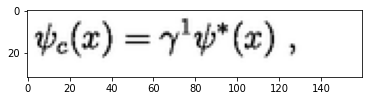

==================== Target ====================

\psi _ { c } ( x ) = \gamma ^ { 1 } \psi ^ { * } ( x ) \ ,

==================== Prediction ====================

\psi _ { c } ( x ) = \gamma ^ { 1 } \psi ^ { * } ( x ) \; ,


In [56]:
print_inference_data(80)

$$\psi _ { c } ( x ) = \gamma ^ { 1 } \psi ^ { * } ( x ) \; ,$$

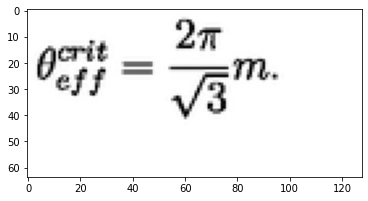

==================== Target ====================

\theta _ { e f f } ^ { c r i t } = \frac { 2 \pi } { \sqrt { 3 } } m .

==================== Prediction ====================

\theta _ { e f f } ^ { e r h } = \frac { 2 \pi } { \sqrt { 3 } } m .


In [63]:
print_inference_data(700)

$$\theta _ { e f f } ^ { e r h } = \frac { 2 \pi } { \sqrt { 3 } } m .$$

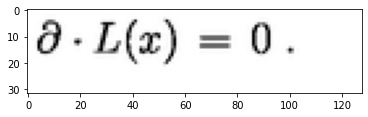

==================== Target ====================

\partial \cdot L ( x ) \, = \, 0 \; .

==================== Prediction ====================

\partial \cdot L ( x ) = 0 \; .


In [71]:
print_inference_data(1900)

$$\partial \cdot L ( x ) = 0 \; .$$

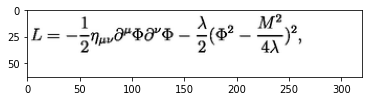

==================== Target ====================

L = - \frac { 1 } { 2 } \eta _ { \mu \nu } \partial ^ { \mu } \Phi \partial ^ { \nu } \Phi - \frac { \lambda } { 2 } ( \Phi ^ { 2 } - \frac { M ^ { 2 } } { 4 \lambda } ) ^ { 2 } ,

==================== Prediction ====================

L = - \frac { M ^ { 2 } } { 2 } \eta _ { \mu \nu } \partial ^ { \nu } \Phi \partial ^ { \nu } \Phi - \frac { M ^ { 2 } } { 4 \lambda } ) ^ { 2 } ,


In [76]:
print_inference_data(380)

$$ L = - \frac { M ^ { 2 } } { 2 } \eta _ { \mu \nu } \partial ^ { \nu } \Phi \partial ^ { \nu } \Phi - \frac { M ^ { 2 } } { 4 \lambda } ) ^ { 2 } ,$$

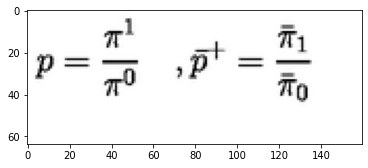

==================== Target ====================

p = \frac { \pi ^ { 1 } } { \pi ^ { 0 } } \quad , { \bar { p } } ^ { + } = \frac { \bar { \pi } _ { 1 } } { { \bar { \pi } } _ { 0 } }

==================== Prediction ====================

p = \frac { \pi ^ { 1 } } { \pi ^ { 0 } } \quad , \bar { \rho } ^ { + } = \frac { \pi ^ { 1 } } { \pi ^ { 0 } }


In [79]:
print_inference_data(900)

$$ p = \frac { \pi ^ { 1 } } { \pi ^ { 0 } } \quad , \bar { \rho } ^ { + } = \frac { \pi ^ { 1 } } { \pi ^ { 0 } } $$